# Logistic Regression Titanic Dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report

In [2]:
titanic = pd.read_csv("./data/titanic-train.csv")
titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Survived - Survival (0 = No; 1 = Yes)<br>
Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)<br>
Name - Name<br>
Sex - Sex<br>
Age - Age<br>
SibSp - Number of Siblings/Spouses Aboard<br>
Parch - Number of Parents/Children Aboard<br>
Ticket - Ticket Number<br>
Fare - Passenger Fare (British pound)<br>
Cabin - Cabin<br>
Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

### Checking for missing values
Are there any missing values in the dataset?? Lets check

In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


In [4]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Ok, so there are only 891 rows in the titanic data frame. Cabin is almost all missing values, so we can drop that variable completely, but what about age? Age seems like a relevant predictor for survival right? We'd want to keep the variables, but it has 177 missing values. Yikes!! We are going to need to find a way to approximate for those missing values!

### Taking care of missing values
drop all the variables that aren't relevant for prediction. Following ARE important:
- Survived - This variable is obviously relevant.
- Pclass - Does a passenger's class on the boat affect their survivability?
- Sex - Could a passenger's gender impact their survival rate?
- Age - Does a person's age impact their survival rate?
- SibSp - Does the number of relatives on the boat (that are siblings or a spouse) affect a person survivability? Probability
- Parch - Does the number of relatives on the boat (that are children or parents) affect a person survivability? Probability
- Fare - Does the fare a person paid effect his survivability? Maybe - let's keep it.
- Embarked - Does a person's point of embarkation matter? It depends on how the boat was filled... Let's keep it.

NOT Important
- persons name
- ticket number
- passenger ID number
- Cabin

In [5]:
titanic_data = titanic.drop(['PassengerId','Name','Ticket','Cabin'], 1)
print(titanic_data.head())
titanic_data.isnull().sum()

   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.1000        S
4         0       3    male  35.0      0      0   8.0500        S


Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

## Let's visualize some data!

0    549
1    342
Name: Survived, dtype: int64


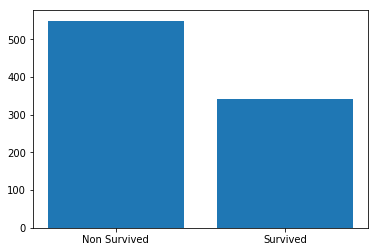

In [6]:
print(titanic['Survived'].value_counts())
objects = ('Non Survived', 'Survived')

plt.bar(range(len(objects)), titanic['Survived'].value_counts(), align="center")
plt.xticks(range(len(objects)), objects)
plt.show()

## Can you draw a bar chart of people who survived, gender wise?

In [7]:
df = titanic.groupby(['Sex','Survived']).size()
print(df.head())
df=df.unstack()
df

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
dtype: int64


Survived,0,1
Sex,,
female,81,233
male,468,109


## Similarly can you show number of passengers who survived according to PClass and Age?

## Imputing missing Age values
How to do this?

Lets see a relation between age and passenger class

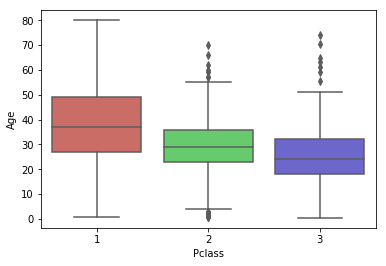

In [8]:
sb.boxplot(x='Pclass', y='Age', data=titanic_data, palette='hls')

we could say that the younger a passenger is, the more likely it is for them to be in 3rd class. The older a passenger is, the more likely it is for them to be in 1st class. 

So, let's write a function that approximates a passengers age, based on their class. From the box plot, it looks like the average age of 1st class passengers is about 37, 2nd class passengers is 29, and 3rd class pasengers is 24.

So let's write a function that finds each null value in the Age variable, and for each null, checks the value of the Pclass and assigns an age value according to the average age of passengers in that class.

In [9]:
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [10]:
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

When we apply the function and check again for null values, we see that there are no more null values in the age variable.

In [11]:
titanic_data['Age'] = titanic_data[['Age', 'Pclass']].apply(age_approx, axis=1) #along the row 
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [12]:
#removing the 2 NA rows
titanic_data.dropna(inplace=True)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

## Checking independence between variables

### Correlation is only between numerical values

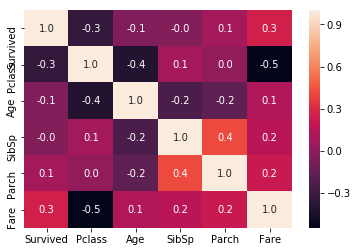

In [13]:
sb.heatmap(titanic_data.corr(), annot=True, fmt='.1f')  

In [14]:
titanic_data = titanic_data.drop(['Fare'], axis=1)

### Converting categorical variables to a dummy indicators

In [15]:
#drop first = remove the first column of result, since this is binary, 0 or 1 is enough, make it false and check
gender = pd.get_dummies(titanic_data['Sex'],drop_first=True)
gender.head()

,male
0,1
1,0
2,0
3,0
4,1


In [16]:
embark_location = pd.get_dummies(titanic_data['Embarked'],drop_first=True)
embark_location.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [17]:
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S


In [18]:
titanic_data.drop(['Sex', 'Embarked'],axis=1,inplace=True)
titanic_data.head()

,Survived,Pclass,Age,SibSp,Parch
0,0,3,22.0,1,0
1,1,1,38.0,1,0
2,1,3,26.0,0,0
3,1,1,35.0,1,0
4,0,3,35.0,0,0


In [19]:
titanic_dmy = pd.concat([titanic_data,gender,embark_location],axis=1)
titanic_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,male,Q,S
0,0,3,22.0,1,0,1,0,1
1,1,1,38.0,1,0,0,0,0
2,1,3,26.0,0,0,0,0,1
3,1,1,35.0,1,0,0,0,1
4,0,3,35.0,0,0,1,0,1


## Look at Fare & Pclass, do we really require Fare when PClass is known? Is it giving any extra information?

In [20]:
all_cols = titanic_dmy.columns.values
X_cols = [i for i in all_cols if i != "Survived"]
X = titanic_dmy[X_cols]
y = titanic_dmy['Survived']

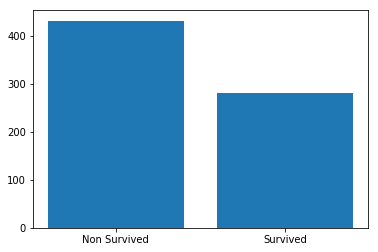

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2432)

objects = ('Non Survived', 'Survived')

plt.bar(range(len(objects)), y_train.value_counts(), align="center")
plt.xticks(range(len(objects)), objects)
plt.show()

### Performing logisitic regression

In [47]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Reading test data set

In [48]:
y_pred = logreg.predict(X_test)
# list(y_pred)
print('Accuracy %.6f'% (logreg.score(X_test, y_test)))

Accuracy 0.807175


In [49]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_test, y_pred)
c

array([[121,  17],
       [ 26,  59]], dtype=int64)

In [50]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.82      0.88      0.85       138
          1       0.78      0.69      0.73        85

avg / total       0.81      0.81      0.80       223



In [51]:
from sklearn.metrics import roc_curve, auc

p = logreg.predict_proba(X_test)
false_positive_rate, recall, thresholds = roc_curve(y_test, p[:, 1])
roc_auc = auc(false_positive_rate, recall)

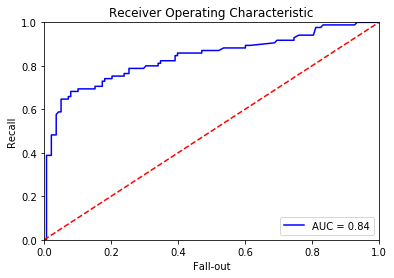

In [52]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--') # against a uniform random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()